# Monte Carlo Localizationのリサンプリング

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、移動ロボットの自己位置推定に使われるMonte Carlo Localization（MCL）のデッドレコニングを実装したものです。


In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

## ランドマークの管理クラス

観測しないので描画用です。

In [2]:
class Landmarks:
    def __init__(self,array):
        self.positions = array
    
    def draw(self):
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
        

### ランドマークを3つ環境に置く

観測しないので描画用です。

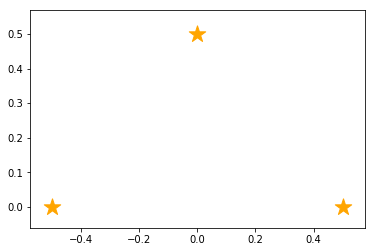

In [3]:
actual_landmarks = Landmarks(np.array([[-0.5,0.0],[0.5,0.0],[0.0,0.5]]))
actual_landmarks.draw()

### パーティクルのクラスとパーティクルフィルタのクラス

In [4]:
# パーティクルのクラス。単なる構造体
class Particle:
    def __init__(self,x,y,t,w):
        self.pos = np.array([x,y,t])
        self.w = w

# パーティクルフィルタのクラス
class ParticleFilter:
    # この実装ではコンストラクタはパーティクルの個数だけを引数にとる
    def __init__(self,num):
        # 空のパーティクルのリストを作って一つずつ追加していく（実装がベタ）
        self.particles = []
        for i in range(num):
            self.particles.append(Particle(0.0,0.0,0.0,1.0/num))    # パーティクルは重みを持つ。全パーティクルの重みの合計は1。1つのパーティクルの重みは1/個数
            
    # ロボットが動いたときにパーティクルを動かすためのメソッド
    # 引数の「motion」はメソッドで、ロボットの移動を再現するためのもの。
    # ロボットは自身がどのように動作するとどう姿勢が変化するかを知っており、このメソッドがその知識となる。
    def moveParticles(self,fw,rot,motion):        
        # パーティクルごとに移動した後の姿勢を計算し、姿勢を更新する。
        for p in self.particles:
            after = motion(p.pos,fw,rot) 
            p.pos = after
            
    # 描画用
    def draw(self,c="blue",lbl="particles"):
        xs = [p.pos[0] for p in self.particles]
        ys = [p.pos[1] for p in self.particles]
        vxs = [math.cos(p.pos[2]) for p in self.particles]
        vys = [math.sin(p.pos[2]) for p in self.particles]
        plt.quiver(xs,ys,vxs,vys,color=c,label=lbl,alpha=0.7)

### ロボットを表現するクラス

ロボットは1ステップ移動を繰り返します。

In [5]:
class Robot:
    def __init__(self,x,y,rad):
        random.seed()
        
        # actual_poses: ロボットの姿勢の真値を1ステップごとに記録したもの
        # （ロボットのクラス内にいるけどロボットはこの情報を使えない）
        self.actual_poses = [np.array([x,y,rad])]
        self.pf = ParticleFilter(30)
    
    #　ロボットの動作をシミュレートするメソッド。シミュレーションだけでなく、ロボットがパーティクルを移動するときにも用いる。
    # つまり実機に実装する場合もこのメソッドが必要となる。雑音の度合いは事前に計測するか、
    # ざっくり決めてフィルタのロバスト性に頼る。
    def motion(self, pos, fw, rot):
        # fwだけ前進してその後rotだけ回転。雑音を混入させる
        actual_fw = random.gauss(fw,fw/10)    #進む距離に対して標準偏差10%の雑音を混入
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進方向がヨレる雑音を標準偏差3[deg]で混入
        
        px, py, pt = pos
        # 移動後の位置を算出
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        # 雑音込みの回転各を算出。rotに対して標準偏差10%の雑音を混ぜる
        actual_rot = random.gauss(rot,rot/10)
        t = pt + dir_error + actual_rot      # さらにヨレの分の角度を足す
        
        return np.array([x,y,t])
    
    # ロボットが動くときに呼び出すメソッド。ロボットの位置の更新とパーティクルの位置の更新
    def move(self,fw,rot):
        self.actual_poses.append(self.motion(self.actual_poses[-1],fw,rot))
        self.pf.moveParticles(fw,rot,self.motion)
        
    # 描画用
    def draw(self,sp,observations):
        self.pf.draw("blue","particles (no observations)")
        
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")

## 描画用の関数

説明は割愛。

In [6]:
def draw(i,observations):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)

    robot.draw(sp,observations)
    
    actual_landmarks.draw()

    plt.legend()

## シミュレーションの実行

リサンプリングすると、分布が縮んでしまうことが分かります。

図の説明: 

* 赤の矢印: 真の姿勢
* 星: ランドマークの位置
* 青の矢印: パーティクルの姿勢
* 灰色の矢印: リサンプリングしない時のパーティクルの姿勢
* 桃色の矢印: リサンプリングする時のパーティクルの姿勢

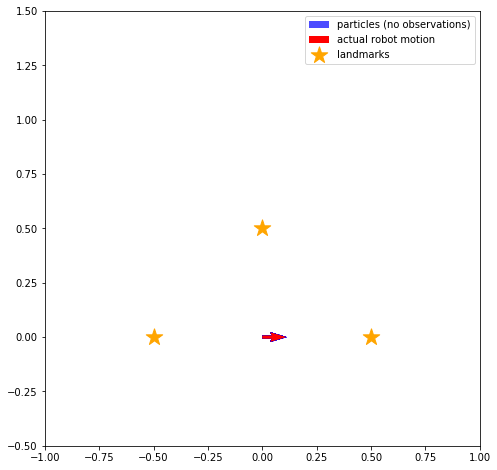

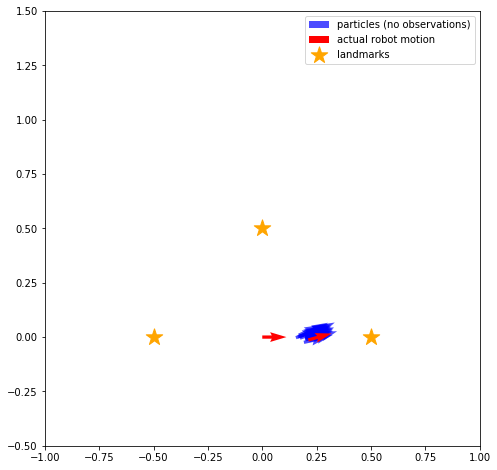

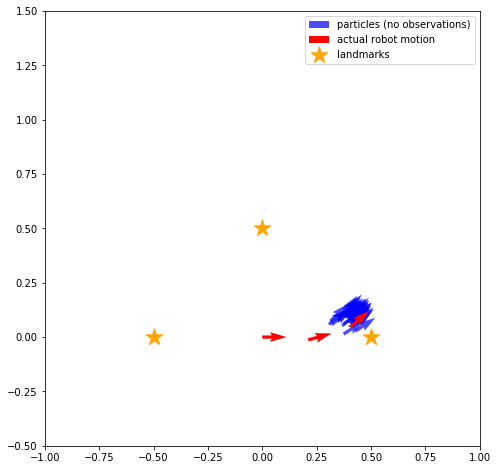

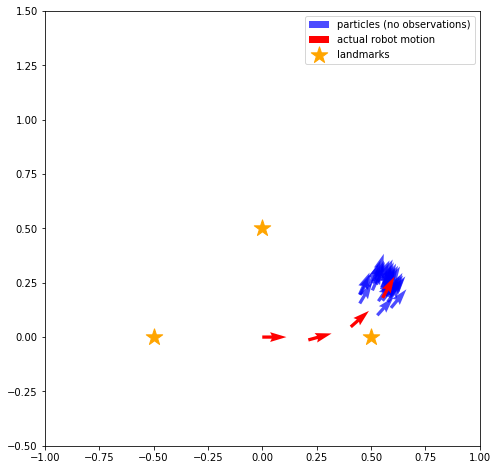

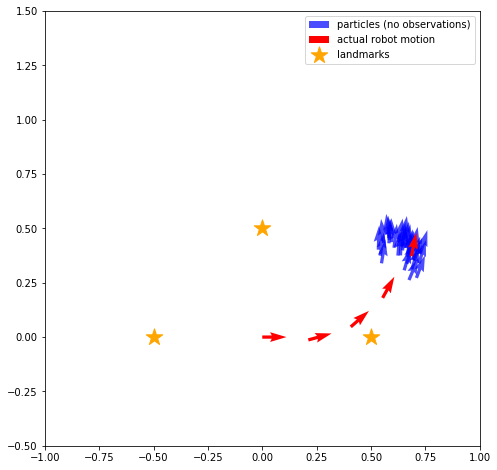

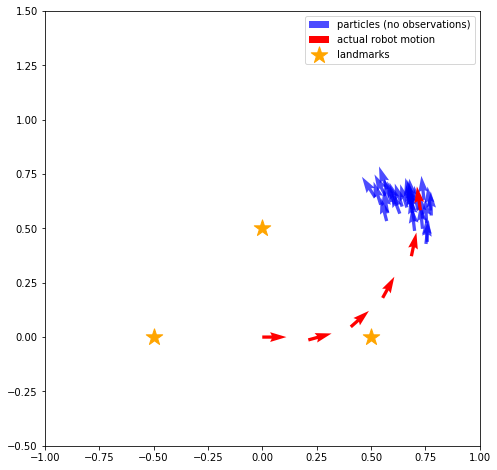

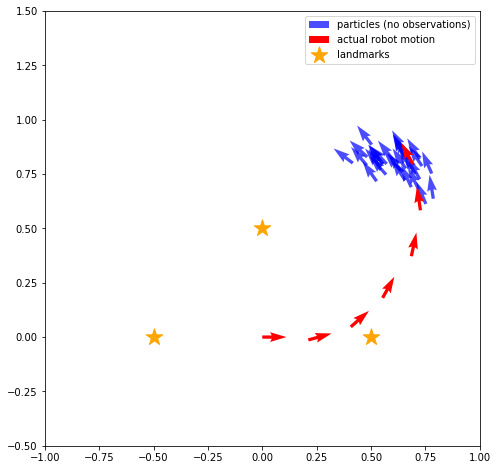

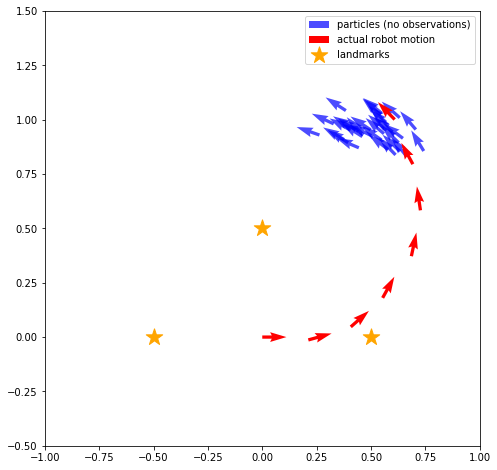

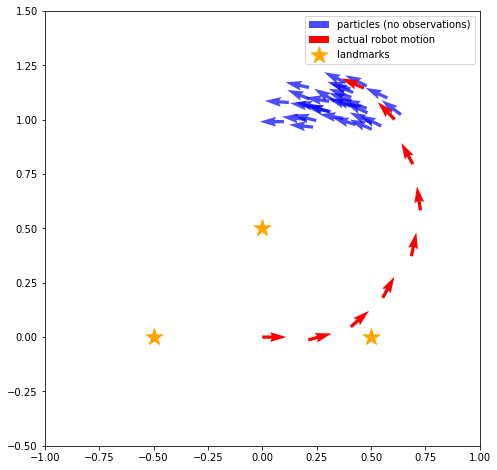

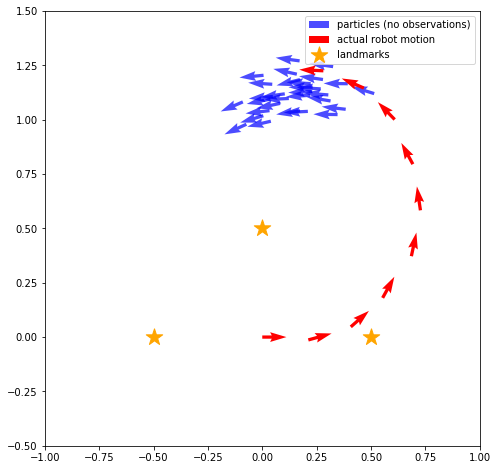

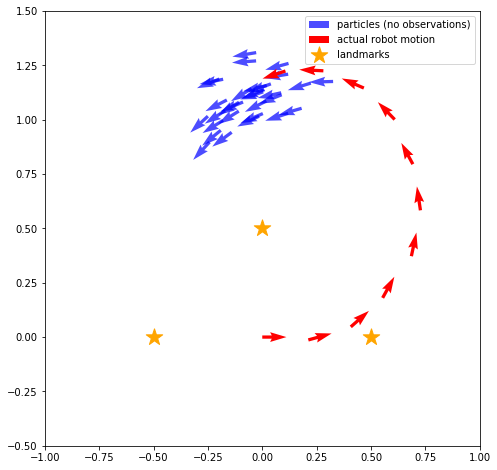

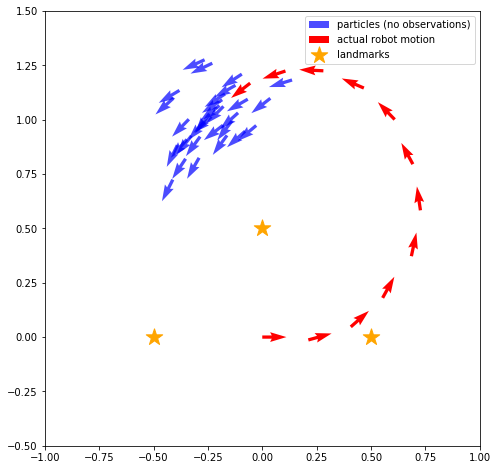

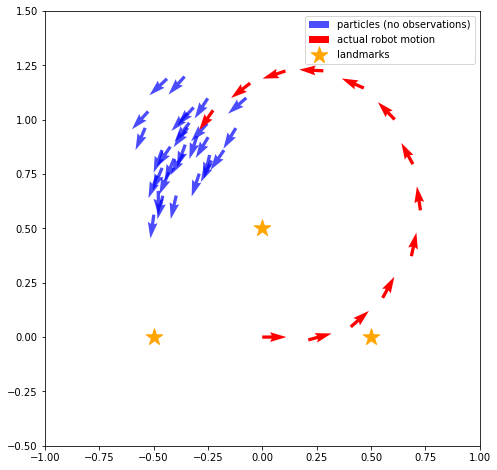

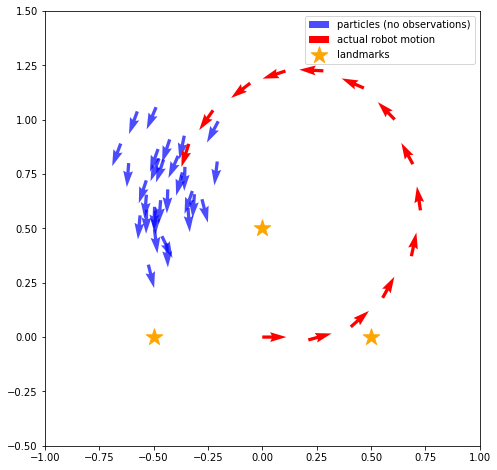

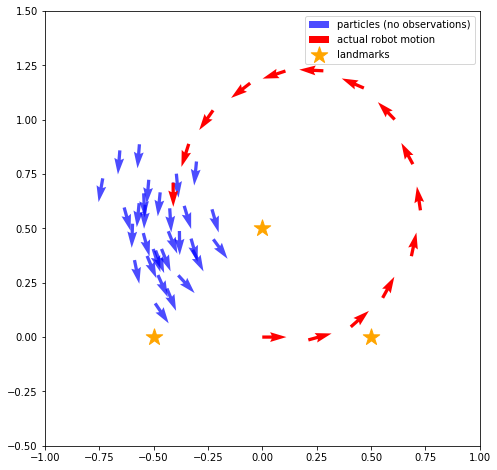

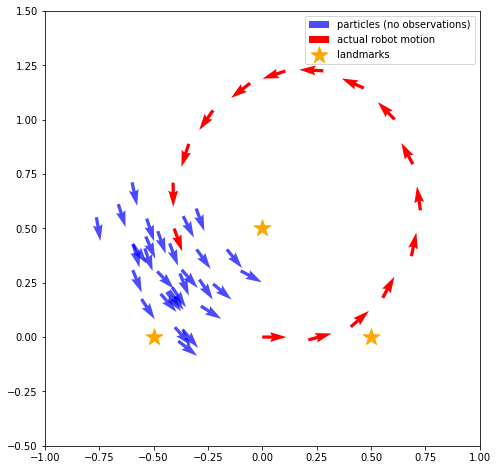

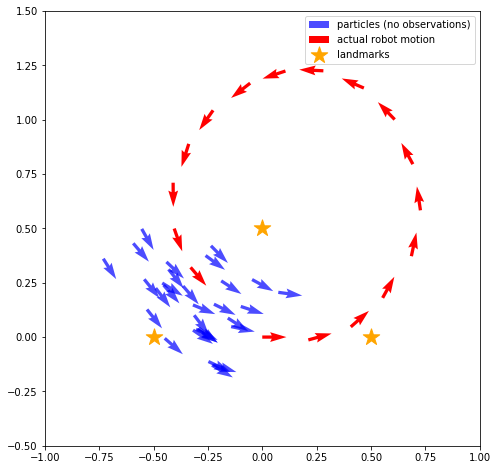

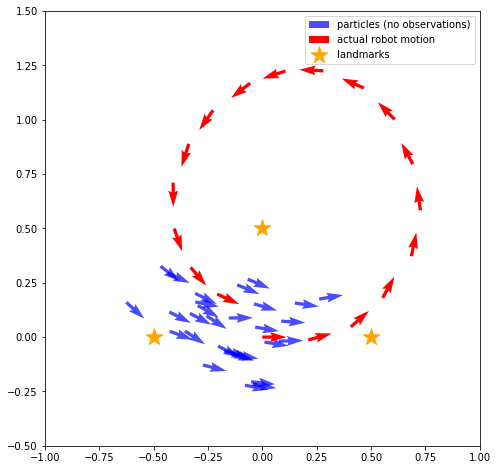

In [7]:
robot = Robot(0,0,0)      # ロボットを原点に

# 観測、描画、移動の繰り返し
for i in range(0,18):
    draw(i,None)
    robot.move(0.2,math.pi / 180.0 * 20)